Referred to tutorial [here](https://machinelearningmastery.com/how-to-develop-a-generative-adversarial-network-for-a-cifar-10-small-object-photographs-from-scratch/?fbclid=IwAR2FetsF4lEoXrPsiXLAmEFdyOxQFRxjhwerJouxbTCfjafMO8JwMFuw70g) 

## Load libraries

In [1]:
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy import vstack
from numpy.random import randn
from numpy.random import randint
from tensorflow import keras
from keras.datasets.cifar10 import load_data
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout
from matplotlib import pyplot
import numpy as np

## Define discriminator

In [2]:
# define the standalone discriminator model
def define_discriminator(in_shape=(32,32,3)):
	model = Sequential()
	# normal
	model.add(Conv2D(64, (3,3), padding='same', input_shape=in_shape))
	model.add(LeakyReLU(alpha=0.2))
	# downsample
	model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# downsample
	model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# downsample
	model.add(Conv2D(256, (3,3), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# classifier
	model.add(Flatten())
	model.add(Dropout(0.4))
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	opt = keras.optimizers.Adam(lr=0.0002, beta_1=0.5) # Adam SGD momentum 0.5
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
	return model

## Define generator

In [3]:
# define the standalone generator model
def define_generator(latent_dim):
	model = Sequential()
	# foundation for 4x4 image
	n_nodes = 256 * 4 * 4
	model.add(Dense(n_nodes, input_dim=latent_dim))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Reshape((4, 4, 256)))
	# upsample to 8x8
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# upsample to 16x16
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# upsample to 32x32
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# output layer
	model.add(Conv2D(3, (3,3), activation='tanh', padding='same'))
	return model

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input

## Load data

In [4]:
# load and prepare cifar10 training images
def load_real_samples():
	# load cifar10 dataset
  (trainX, trainY), (_, _) = load_data()
  # convert from unsigned ints to floats
  X = trainX.astype('float32')
  # get just cats and dogs from cifar10
  X = X[np.isin(trainY, [3, 5]).flatten()]
	# scale from [0,255] to [-1,1]
  X = (X - 127.5) / 127.5
  return X
 
# select real samples (shuffle training dataset)
def generate_real_samples(dataset, n_samples):
	# choose random instances
	ix = randint(0, dataset.shape[0], n_samples)
	# retrieve selected images
	X = dataset[ix]
	# generate 'real' class labels (1)
	y = ones((n_samples, 1))
	return X, y

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(g_model, latent_dim, n_samples):
	# generate points in latent space
	x_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	X = g_model.predict(x_input)
	# create 'fake' class labels (0)
	y = zeros((n_samples, 1))
	return X, y

## Train the generator model

In [5]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
	# make weights in the discriminator not trainable
	d_model.trainable = False
	# connect them
	model = Sequential()
	# add generator
	model.add(g_model)
	# add the discriminator
	model.add(d_model)
	# compile model
	opt = keras.optimizers.Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model

# create and save a plot of generated images
def save_plot(examples, epoch, n=7):
	# scale from [-1,1] to [0,1]
  examples = (examples + 1) / 2.0
  print(examples.shape)
	# plot images
  for i in range(n * n):
		# define subplot
    pyplot.subplot(n, n, 1 + i)
		# turn off axis
    pyplot.axis('off')
		# plot raw pixel data
    pyplot.imshow(examples[i])
	# save plot to file
  filename = 'generated_plot_dog_cat%03d.png' % (epoch+1)
  pyplot.savefig(filename)
  pyplot.close()
 
# evaluate the discriminator, plot generated images, save generator model
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=150):
	# prepare real samples
	X_real, y_real = generate_real_samples(dataset, n_samples)
	# evaluate discriminator on real examples
	_, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
	# prepare fake examples
	x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
	# evaluate discriminator on fake examples
	_, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
	# summarize discriminator performance
	print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
	# save plot
	save_plot(x_fake, epoch)
	# save the generator model tile file
	filename = 'generator_model_dog%03d.h5' % (epoch+1)
	g_model.save(filename)
 
# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=200, n_batch=128):
	bat_per_epo = int(dataset.shape[0] / n_batch)
	half_batch = int(n_batch / 2)
	# manually enumerate epochs
	for i in range(n_epochs):
		# enumerate batches over the training set
		for j in range(bat_per_epo):
			# get randomly selected 'real' samples
			X_real, y_real = generate_real_samples(dataset, half_batch)
			# update discriminator model weights
			d_loss1, _ = d_model.train_on_batch(X_real, y_real)
			# generate 'fake' examples
			X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
			# update discriminator model weights
			d_loss2, _ = d_model.train_on_batch(X_fake, y_fake)
			# prepare points in latent space as input for the generator
			X_gan = generate_latent_points(latent_dim, n_batch)
			# create inverted labels for the fake samples
			y_gan = ones((n_batch, 1))
			# update the generator via the discriminator's error
			g_loss = gan_model.train_on_batch(X_gan, y_gan)
			# summarize loss on this batch
			print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' %
				(i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))
		summarize_performance(i, g_model, d_model, dataset, latent_dim)

## Get model structure

In [6]:
# get discriminator model layer summary
print("Discriminator model")
model_d = define_discriminator()
model_d.summary()

# get generator model layer summary
print("\nGenerator model")
model_g = define_generator(100) # for latent_dim
model_g.summary()

# get gan model layer summary
print("\nGAN model")
model_gan = define_gan(model_g, model_d)
model_gan.summary()

Discriminator model
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        1792      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       73856     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 128)         147584    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 conv2d_3 (Conv2D)           (None, 

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)



Generator model
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 4096)              413696    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 4096)              0         
                                                                 
 reshape (Reshape)           (None, 4, 4, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 8, 8, 128)        524416    
 nspose)                                                         
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 16, 16, 128)      262272    
 ranspose)                           

In [7]:
# size of the latent space
latent_dim = 100
# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# load image data
dataset = load_real_samples()

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


170508288/170498071 [==============================] - 4s 0us/step


In [ ]:
# train model
train(g_model, d_model, gan_model, dataset, latent_dim)

串流輸出內容已截斷至最後 5000 行。
>53, 3/78, d1=0.659, d2=0.602 g=0.946
>53, 4/78, d1=0.543, d2=0.729 g=0.918
>53, 5/78, d1=0.654, d2=0.667 g=0.883
>53, 6/78, d1=0.643, d2=0.830 g=0.906
>53, 7/78, d1=0.675, d2=0.726 g=0.945
>53, 8/78, d1=0.728, d2=0.750 g=0.997
>53, 9/78, d1=0.782, d2=0.674 g=1.050
>53, 10/78, d1=0.760, d2=0.539 g=1.037
>53, 11/78, d1=0.657, d2=0.634 g=1.039
>53, 12/78, d1=0.739, d2=0.662 g=1.065
>53, 13/78, d1=0.691, d2=0.703 g=0.990
>53, 14/78, d1=0.689, d2=0.710 g=1.022
>53, 15/78, d1=0.605, d2=0.627 g=1.097
>53, 16/78, d1=0.672, d2=0.612 g=1.089
>53, 17/78, d1=0.711, d2=0.516 g=1.117
>53, 18/78, d1=0.691, d2=0.510 g=1.161
>53, 19/78, d1=0.622, d2=0.511 g=1.155
>53, 20/78, d1=0.531, d2=0.532 g=1.080
>53, 21/78, d1=0.521, d2=0.643 g=1.094
>53, 22/78, d1=0.486, d2=0.549 g=1.051
>53, 23/78, d1=0.576, d2=0.598 g=1.068
>53, 24/78, d1=0.580, d2=0.728 g=1.001
>53, 25/78, d1=0.559, d2=0.571 g=1.070
>53, 26/78, d1=0.607, d2=0.585 g=1.085
>53, 27/78, d1=0.584, d2=0.509 g=1.162
>53, 28/78,

## Use models to generate images

In [1]:
# example of loading the generator model and generating images
from keras.models import load_model
from numpy.random import randn
from matplotlib import pyplot

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input

# plot the generated images
def create_plot(examples, n):
	# plot images
	for i in range(n * n):
		# define subplot
		pyplot.subplot(n, n, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(examples[i, :, :])
	pyplot.show()

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [15]:
!ls

generator_model_dog015.h5  generator_model_dog107.h5  generator_model_dog110.h5
generator_model_dog030.h5  generator_model_dog108.h5  generator_model_dog112.h5
generator_model_dog100.h5  generator_model_dog109.h5  generator_model_dog113.h5


In [17]:
# load model
model_015 = load_model('generator_model_dog015.h5')
model_030 = load_model('generator_model_dog030.h5')
model_100 = load_model('generator_model_dog100.h5')
model_109 = load_model('generator_model_dog109.h5')
model_113 = load_model('generator_model_dog113.h5')

In [18]:
# generate images
latent_points = generate_latent_points(100, 25)

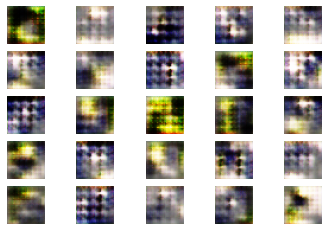

In [19]:
# generate images
X = model_015.predict(latent_points)
# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0
# plot the result
create_plot(X, 5)

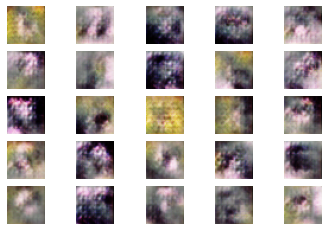

In [20]:
# generate images
X = model_030.predict(latent_points)
# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0
# plot the result
create_plot(X, 5)

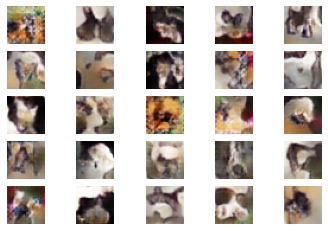

In [21]:
# generate images
X = model_100.predict(latent_points)
# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0
# plot the result
create_plot(X, 5)

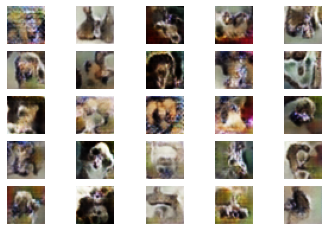

In [22]:
# generate images
X = model_109.predict(latent_points)
# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0
# plot the result
create_plot(X, 5)

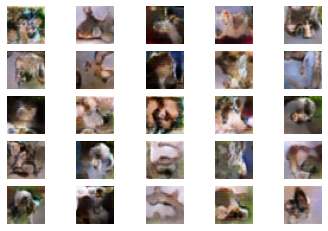

In [23]:
# generate images
X = model_113.predict(latent_points)
# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0
# plot the result
create_plot(X, 5)